# Florence-2-large sample usage

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [2]:
pip install timm flash_attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.3 MB/s eta 0:00:00
  Created wheel for flash_attn: filename=flash_attn-2.6.3-cp310-cp310-linux_x86_64.whl size=187309225 sha256=237ef9c6157db394e1ddde4ba609a21ebb98382377a27041edc09318801a6f24
  Stored in directory: /root/.cache/pip/wheels/7e/e3/c3/89c7a2f3c4adc07cd1c675f8bb7b9ad4d18f64a72bccdfe826
Successfully built flash_attn


In [3]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## define the prediction function

In [12]:
def run_example(task_prompt, text_input=None,images=image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=images, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image

In [13]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [10]:
# prompt: load /content/test_detection.jpg as Image

from PIL import Image

image1 = Image.open('/content/test_detection.jpg')

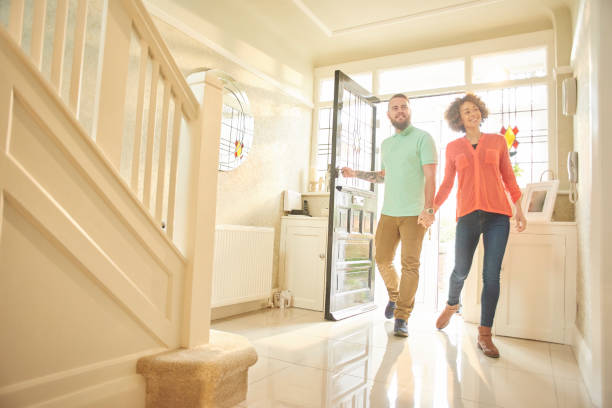

In [11]:
image1

## Run pre-defined tasks without additional inputs

### Caption

In [16]:
task_prompt = '<CAPTION>'
run_example(task_prompt, images=image1)

{'<CAPTION>': 'A man and woman walking down a hallway holding hands.'}

In [17]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt,images=image1)

{'<DETAILED_CAPTION>': 'The image shows a happy couple walking down the hallway of their new home, holding hands and smiling. We can see a staircase with a railing on the left side of the image, a door in the background, cupboards with various objects on them, a clock on the wall, and a window.'}

In [18]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt,images=image1)

{'<MORE_DETAILED_CAPTION>': 'The image shows a young couple walking down a hallway in a house. The hallway has a white tiled floor and a wooden staircase on the left side. The man is wearing a green t-shirt and khaki pants, and the woman is wearing an orange top and blue jeans. They are both smiling and holding hands as they walk towards the door. The door is open, and there is a window on the right side of the image. The walls are painted in a light beige color and there are a few decorative items hanging on the wall. The couple appears to be happy and enjoying their time together.'}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [19]:
task_prompt = '<OD>'
results = run_example(task_prompt,images=image1)
print(results)

{'<OD>': {'bboxes': [[292.79998779296875, 253.67999267578125, 344.6399841308594, 366.9599914550781], [592.9599609375, 178.3199920654297, 605.1199951171875, 239.75999450683594], [592.9599609375, 178.3199920654297, 604.47998046875, 215.75999450683594], [447.03997802734375, 109.68000030517578, 552.6400146484375, 421.67999267578125], [354.239990234375, 109.68000030517578, 459.1999816894531, 397.1999816894531], [219.83999633789062, 263.2799987792969, 288.32000732421875, 363.1199951171875], [466.239990234375, 246.47999572753906, 534.0800170898438, 384.7200012207031], [444.47998046875, 244.55999755859375, 454.7200012207031, 252.239990234375]], 'labels': ['cabinetry', 'corded phone', 'door handle', 'person', 'person', 'radiator', 'trousers', 'watch']}}


In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

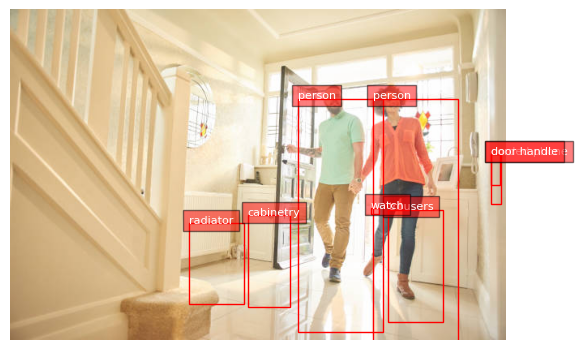

In [21]:
plot_bbox(image1, results['<OD>'])

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [22]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt,images=image1)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[447.03997802734375, 109.68000030517578, 553.2799682617188, 421.67999267578125], [354.8800048828125, 109.68000030517578, 459.8399963378906, 397.1999816894531], [466.8799743652344, 246.47999572753906, 534.0800170898438, 385.1999816894531], [219.83999633789062, 263.2799987792969, 288.32000732421875, 363.1199951171875], [292.79998779296875, 253.67999267578125, 344.0, 366.9599914550781], [227.51998901367188, 102.0, 265.91998291015625, 201.83999633789062], [592.9599609375, 178.3199920654297, 605.1199951171875, 239.75999450683594], [444.47998046875, 244.55999755859375, 454.7200012207031, 252.239990234375]], 'labels': ['woman in coral blouse and blue jeans walking in hallway', 'man in green polo shirt and khaki pants walking in front of sliding glass door', 'trousers', 'radiator', 'cabinetry', 'clock', 'corded phone', 'watch']}}


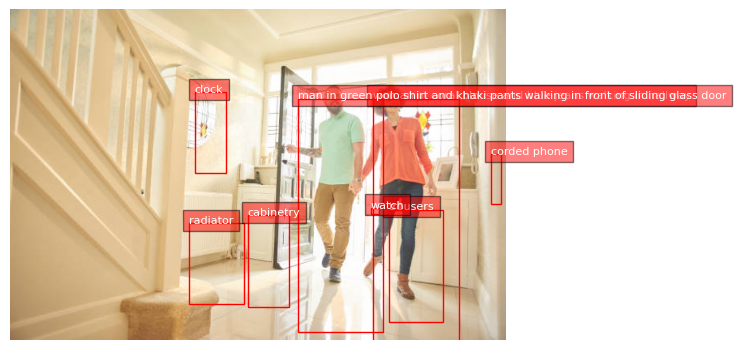

In [23]:
plot_bbox(image1, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [24]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt,images=image1)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[0.3199999928474426, 0.23999999463558197, 639.0399780273438, 479.2799987792969], [446.3999938964844, 109.68000030517578, 553.2799682617188, 421.67999267578125], [354.8800048828125, 109.68000030517578, 459.8399963378906, 397.1999816894531], [340.1600036621094, 81.83999633789062, 399.67999267578125, 378.0], [514.8800048828125, 261.3599853515625, 605.1199951171875, 406.3199768066406], [142.39999389648438, 386.6399841308594, 271.0400085449219, 479.2799987792969], [467.5199890136719, 246.47999572753906, 534.719970703125, 384.7200012207031], [452.79998779296875, 156.239990234375, 547.5199584960938, 258.47998046875], [220.47999572753906, 263.2799987792969, 289.6000061035156, 363.6000061035156], [391.3599853515625, 436.55999755859375, 391.3599853515625, 252.239990234375], [448.3199768066406, 377.03997802734375, 397.1199951171875, 146.16000366210938], [458.55999755859375, 255.1199951171875, 293.44000244140625, 253.67999267578125], [345.2799987792969, 366.959991

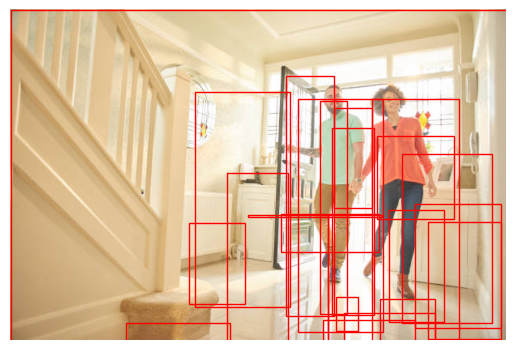

In [25]:
plot_bbox(image1, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [26]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt,text_input="A young couple visiting their new house",images=image1)
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[437.44000244140625, 108.72000122070312, 555.2000122070312, 425.5199890136719], [353.6000061035156, 108.72000122070312, 461.7599792480469, 401.5199890136719], [0.3199999928474426, 1.6799999475479126, 639.0399780273438, 479.2799987792969]], 'labels': ['A young couple', 'A young couple', 'their new house']}}


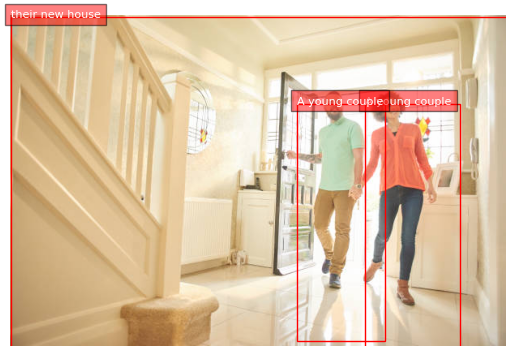

In [27]:
plot_bbox(image1, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [28]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="A young couple",images=image1)
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[466.8799743652344, 130.8000030517578, 468.79998779296875, 127.43999481201172, 470.7200012207031, 123.5999984741211, 473.91998291015625, 120.23999786376953, 475.8399963378906, 117.83999633789062, 477.7599792480469, 115.43999481201172, 480.3199768066406, 114.47999572753906, 483.5199890136719, 114.47999572753906, 485.44000244140625, 113.04000091552734, 487.3599853515625, 110.63999938964844, 489.91998291015625, 109.68000030517578, 491.8399963378906, 109.68000030517578, 495.03997802734375, 110.63999938964844, 496.9599914550781, 112.07999420166016, 500.1600036621094, 114.47999572753906, 503.3599853515625, 117.83999633789062, 505.2799987792969, 120.23999786376953, 507.1999816894531, 122.63999938964844, 508.47998046875, 125.04000091552734, 508.47998046875, 127.43999481201172, 510.3999938964844, 130.8000030517578, 510.3999938964844, 135.59999084472656, 507.1999816894531, 138.95999145507812, 505.2799987792969, 141.36000061035156, 505.279998

In [29]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

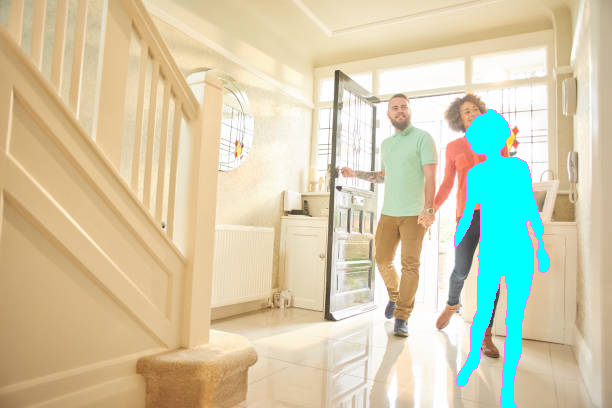

In [30]:
output_image = copy.deepcopy(image1)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999].

In [31]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>",images=image1)
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[477.7599792480469, 263.2799987792969, 505.2799987792969, 263.2799987792969, 505.2799987792969, 272.8800048828125, 504.0, 273.8399963378906, 502.7200012207031, 278.6399841308594, 502.7200012207031, 284.3999938964844, 502.0799865722656, 289.1999816894531, 500.79998779296875, 292.55999755859375, 500.1600036621094, 296.3999938964844, 498.8799743652344, 297.3599853515625, 497.5999755859375, 301.1999816894531, 497.5999755859375, 304.55999755859375, 496.9599914550781, 309.3599853515625, 495.67999267578125, 312.7200012207031, 494.3999938964844, 317.5199890136719, 493.7599792480469, 320.8800048828125, 492.47998046875, 324.239990234375, 491.1999816894531, 326.6399841308594, 489.2799987792969, 329.03997802734375, 488.6399841308594, 331.44000244140625, 487.3599853515625, 334.79998779296875, 487.3599853515625, 337.1999816894531, 485.44000244140625, 340.55999755859375, 484.1600036621094, 344.3999938964844, 482.8799743652344, 347.7599792480469, 482.8799743

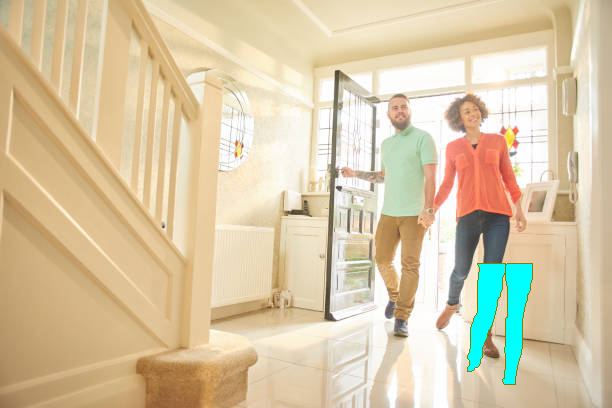

In [32]:
output_image = copy.deepcopy(image1)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [33]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a young couple",images=image1)
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[352.9599914550781, 103.43999481201172, 553.9199829101562, 424.0799865722656]], 'bboxes_labels': ['a young couple'], 'polygons': [], 'polygons_labels': []}}


In [34]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [35]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

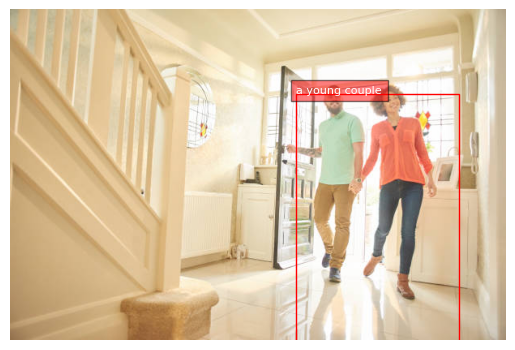

In [36]:
plot_bbox(image1, bbox_results)

### region to texts

In [37]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>",images=image1)
print(results)

{'<REGION_TO_CATEGORY>': 'refrigerator<loc_52><loc_332><loc_932><loc_774>'}


In [38]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>",images=image1)
print(results)

{'<REGION_TO_DESCRIPTION>': 'couple walking in modern kitchen<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [39]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

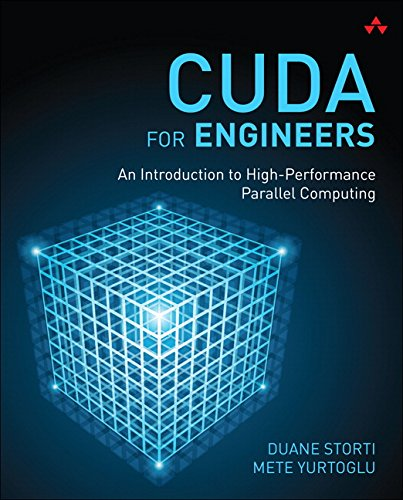

In [40]:
image

In [41]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': '-'}

In [42]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[217.82150268554688, 195.25, 217.82150268554688, 214.75, 213.79150390625, 214.75, 213.79150390625, 195.25]], 'labels': ['</s>٠١٠-٠.٠']}}


In [43]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)

    display(image)

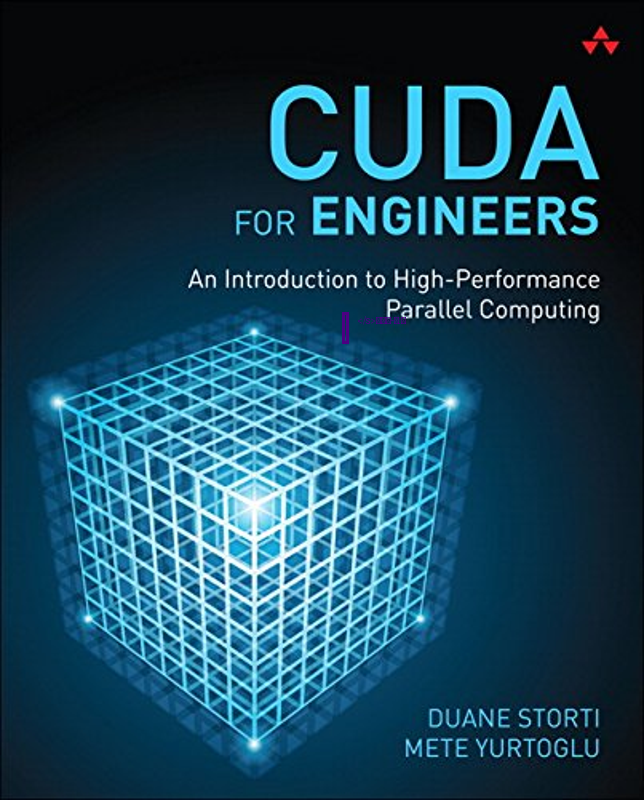

In [44]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)

## Cascaded tasks

### Caption + Phrase Grounding

results format:

{
 '\<CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [45]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [46]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [47]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[354.239990234375,
    109.19999694824219,
    461.7599792480469,
    401.03997802734375],
   [438.0799865722656,
    108.72000122070312,
    555.2000122070312,
    425.5199890136719],
   [0.3199999928474426,
    2.1599998474121094,
    639.0399780273438,
    479.2799987792969],
   [433.5999755859375, 241.67999267578125, 460.47998046875, 275.2799987792969],
   [351.67999267578125,
    192.239990234375,
    376.6399841308594,
    215.27999877929688]],
  'labels': ['A man', 'woman', 'a hallway', 'hands', 'hands']},
 '<CAPTION>': 'A man and woman walking down a hallway holding hands.'}

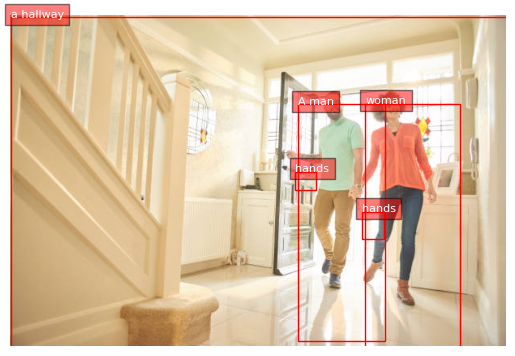

In [48]:
plot_bbox(image1, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding

results format:

{
 '\<DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [49]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt,images=image1)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input,images=image1)
results['<DETAILED_CAPTION>'] = text_input

In [50]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[352.32000732421875,
    104.87999725341797,
    554.5599975585938,
    424.55999755859375],
   [437.44000244140625,
    108.72000122070312,
    553.9199829101562,
    425.03997802734375],
   [351.67999267578125,
    108.72000122070312,
    460.47998046875,
    401.03997802734375],
   [218.55999755859375,
    352.55999755859375,
    623.6799926757812,
    479.2799987792969],
   [218.55999755859375,
    353.03997802734375,
    623.6799926757812,
    479.2799987792969],
   [432.3199768066406,
    241.67999267578125,
    459.1999816894531,
    274.79998779296875],
   [531.5199584960938,
    248.87998962402344,
    555.2000122070312,
    278.6399841308594],
   [351.03997802734375,
    192.239990234375,
    375.3599853515625,
    215.27999877929688],
   [0.3199999928474426,
    2.1599998474121094,
    269.7599792480469,
    479.2799987792969],
   [0.3199999928474426,
    2.1599998474121094,
    270.3999938964844,
    479.2799987792969],
   [0.31

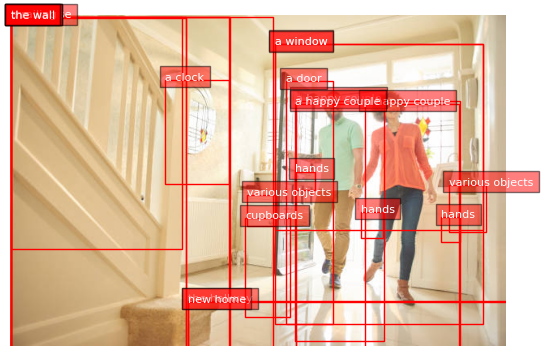

In [51]:
plot_bbox(image1, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding

results format:

{
 '\<MORE_DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [52]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt,images=image1,)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input,images=image1)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [53]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[220.47999572753906,
    352.55999755859375,
    622.3999633789062,
    479.2799987792969],
   [221.1199951171875,
    354.9599914550781,
    622.3999633789062,
    479.2799987792969],
   [0.3199999928474426,
    2.1599998474121094,
    269.7599792480469,
    479.2799987792969],
   [0.3199999928474426,
    2.1599998474121094,
    223.67999267578125,
    479.2799987792969],
   [354.8800048828125,
    108.23999786376953,
    459.1999816894531,
    398.1600036621094],
   [395.1999816894531,
    147.1199951171875,
    458.55999755859375,
    256.55999755859375],
   [390.0799865722656,
    249.36000061035156,
    447.67999267578125,
    377.5199890136719],
   [450.239990234375,
    107.75999450683594,
    552.6400146484375,
    422.6399841308594],
   [465.5999755859375,
    245.51998901367188,
    535.3599853515625,
    385.1999816894531],
   [340.1600036621094, 80.4000015258789, 397.7599792480469, 378.0],
   [326.7200012207031,
    35.279998779

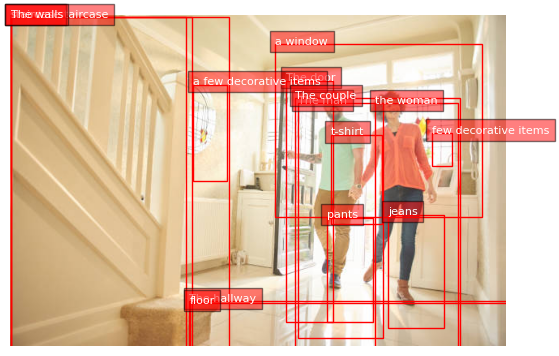

In [54]:
plot_bbox(image1, results['<CAPTION_TO_PHRASE_GROUNDING>'])